# Finding Outliers in time series

Finding outliers in time series is somewhat different from finding outliers in normal data, what isn't considere an outlier in the global data could be an outlier for an specific moment for example.
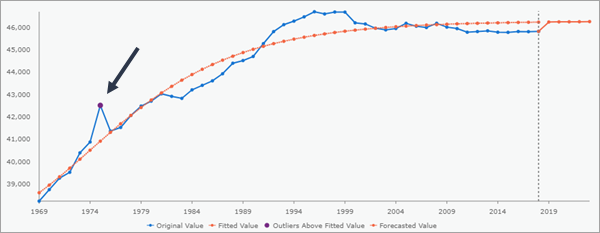

Taken from: https://pro.arcgis.com/en/pro-app/latest/tool-reference/space-time-pattern-mining/understanding-outliers-in-time-series-analysis.htm


In [1]:
import pandas as pd
import seaborn as sns

So for finding outliers several methods are used, in this case we will use a method called sliding window, where we pick a certain amount of data and slide it and threat each window individually
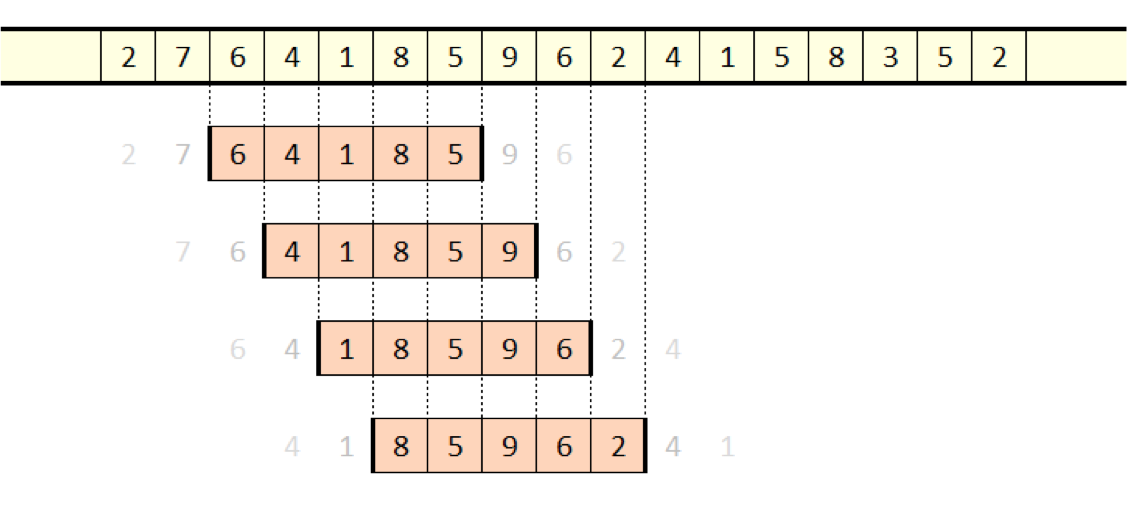

Taken from: https://medium.com/@krzysztofdrelczuk/time-series-anomaly-detection-with-python-example-a92ef262f09a

In [2]:
#create a generator of windows
def window_generator(df,width):
    #if the window is n cells width then we take n/2 cells before and n/2 cells after
    radius=width//2
    for i in range(radius,df.shape[0]-radius):
        #yield with make this function work as an iterable
        yield df.iloc[i-radius:i+radius]

In [3]:
#load excel function
def load_excels(path,names, skip_lines =0):
    dfs=list()
    for name in names:
        dfs.append( pd.read_excel(path+name,usecols="A:D",skiprows=skip_lines))
    return pd.concat(dfs)

In [4]:
files=['Demanda_Energia_SIN_2000.xlsx']
df = load_excels(path='Demanda Comercial SIN/',names=files,skip_lines=3)
#here we reduce the total data frame to simplify visualization, this method works with big amounts of information
df=df[0:30]

Now we have the windows of our dataframe, we want to find outliers, as for the definition of outlier we will use the classical interquartile range(IQR) in which we define the IQR as 
IQR = Q3-Q1
and the data that diverges 1.5*IQR bellow Q1 or 1.5*IQR above Q3 is treated as an outlier
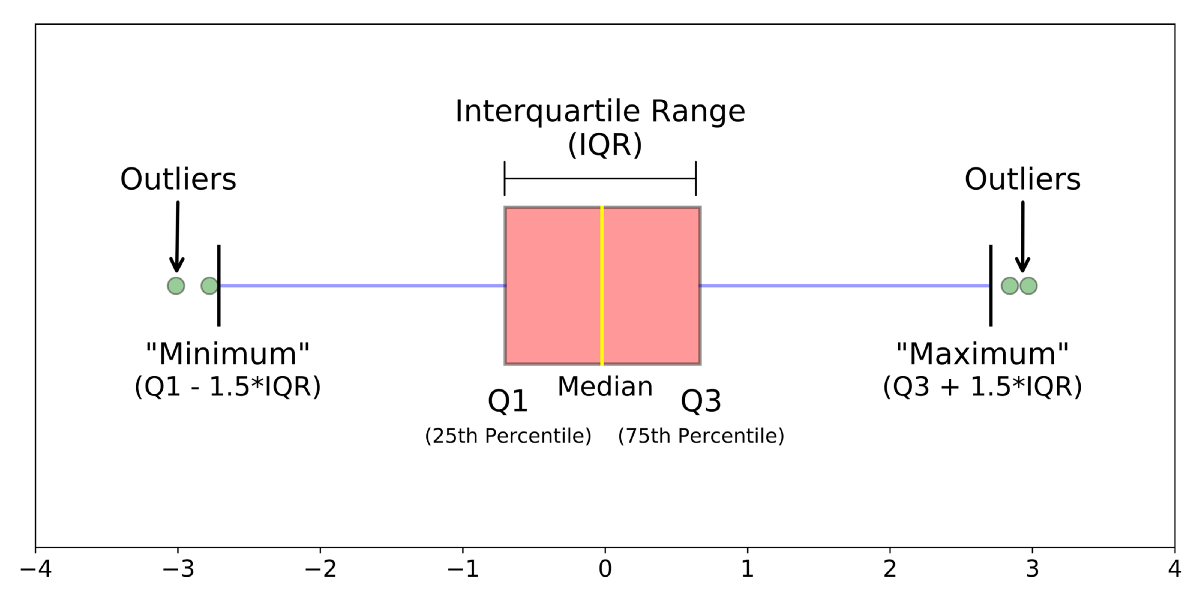
Taken from: https://medium.com/@agarwal.vishal819/outlier-detection-with-boxplots-1b6757fafa21

As for filling the dates where there were outliers we will take the average between the previous and the next date

In [21]:
def get_outlier_indexes(df,width=10):
    outlier_indexes=set()
    #only apply IQR to numeric columns
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for window in window_generator(df,width):
        for column in window.select_dtypes(include=numerics).columns:
            Q1 = window[column].quantile(0.25)
            Q3 = window[column].quantile(0.75)
            IQR = Q3 - Q1
            bottom_limit=Q1-(1.5*IQR)
            upper_limit=Q3+(1.5*IQR)
            #get the indexes of the outliers, notice outlier_indexes is not a list but a set, which means an element taht already exists in the et will not be added twice
            outlier_indexes.update(window.index[(window[column] >= upper_limit) | (window[column] <= bottom_limit)].tolist())
    return outlier_indexes

def fill_outliers(df,outliers):
    df2=df.copy()
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    for i in outliers:
        for column in df2.select_dtypes(include=numerics):
            df2.loc[i,column] = (df2.loc[i-1][column]+df2.loc[i+1][column])/2
    return df2

Text(0.5, 1.0, 'original dataset')

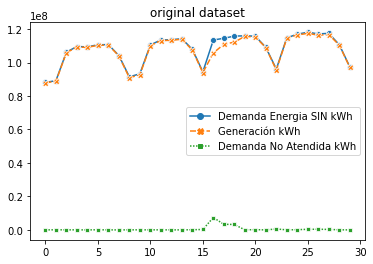

In [18]:
outlier_indexes=get_outlier_indexes(df,20)
outliers=df.index.isin(outlier_indexes)
sns.lineplot(data=df,markers=True).set_title('original dataset')

Text(0.5, 1.0, 'droped outliers dataset')

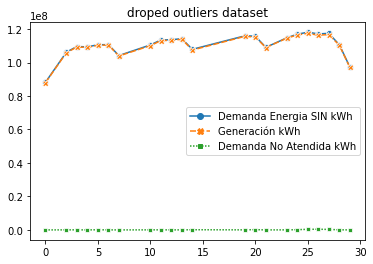

In [19]:
sns.lineplot(data=df[~outliers],markers=True).set_title('droped outliers dataset')

Text(0.5, 1.0, 'filled outliers dataset')

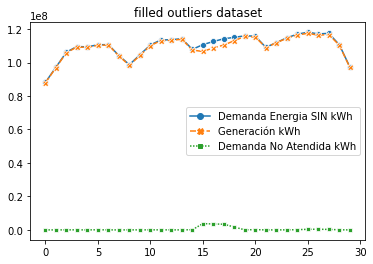

In [22]:
sns.lineplot(data=fill_outliers(df,outlier_indexes),markers=True).set_title('filled outliers dataset')